In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [3]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantV",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = Dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(Dataset)

68

In [7]:
for image_batch, label_batch in Dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 2 1 0 1 1 0 1 1 0]


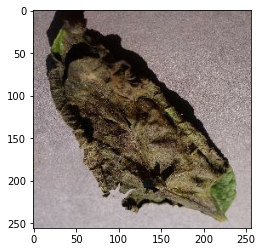

In [8]:
for image_batch, label_batch in Dataset.take(1):
    plt.imshow(image_batch[10].numpy().astype("uint8"))
    

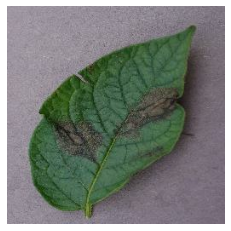

In [9]:
for image_batch, label_batch in Dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")

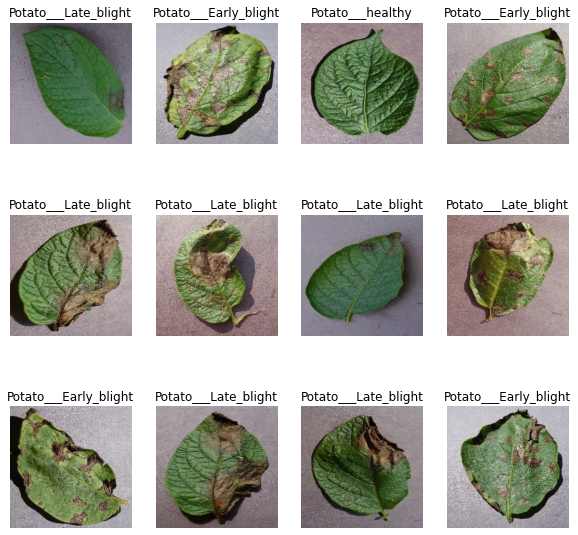

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in Dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
train_size = 0.8
len(Dataset)*train_size

54.400000000000006

In [13]:
train_Ds = Dataset.take(54)
len(train_Ds)

54

In [14]:
test_Ds = Dataset.skip(54)
len(test_Ds)

14

In [15]:
val_Ds = test_Ds.take(6)
len(val_Ds)

6

In [16]:
test_Ds = test_Ds.skip(6)
len(test_Ds)


8

In [17]:
def get_Dataset_partitions_tf(Ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000 ):
    Ds_size = len(Ds)
    
    if shuffle:
        Ds = Ds.shuffle(shuffle_size, seed= 12)
    
    train_size = int(train_split*Ds_size)
    val_size = int(val_split*Ds_size)
    
    train_Ds = Ds.take(train_size)
    val_Ds = Ds.skip(train_size).take(val_size)
    test_Ds = Ds.skip(val_size).skip(train_size)
    
    
    return train_Ds, val_Ds, test_Ds

In [18]:
train_Ds, val_Ds, test_Ds = get_Dataset_partitions_tf(Dataset)

In [19]:
len(train_Ds)

54

In [20]:
len(val_Ds)

6

In [21]:
len(test_Ds)

8

In [22]:
train_Ds = train_Ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_Ds = val_Ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_Ds = test_Ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, 3, activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = 3, activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, 3, activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(n_classes, activation = "softmax"),
    
])

model.build(input_shape = input_shape)


In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [28]:
history = model.fit(
    train_Ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_Ds
    
)

Epoch 1/30
54/54 [==============================] - 101s 2s/step - loss: 0.9039 - accuracy: 0.4514 - val_loss: 0.8551 - val_accuracy: 0.5885
Epoch 2/30
54/54 [==============================] - 93s 2s/step - loss: 0.7567 - accuracy: 0.6152 - val_loss: 0.7724 - val_accuracy: 0.6875
Epoch 3/30
54/54 [==============================] - 93s 2s/step - loss: 0.5762 - accuracy: 0.7436 - val_loss: 0.4562 - val_accuracy: 0.8281
Epoch 4/30
54/54 [==============================] - 94s 2s/step - loss: 0.4431 - accuracy: 0.8050 - val_loss: 0.5649 - val_accuracy: 0.7135
Epoch 5/30
54/54 [==============================] - 92s 2s/step - loss: 0.3775 - accuracy: 0.8351 - val_loss: 0.4243 - val_accuracy: 0.8438
Epoch 6/30
54/54 [==============================] - 93s 2s/step - loss: 0.2972 - accuracy: 0.8837 - val_loss: 0.2756 - val_accuracy: 0.9062
Epoch 7/30
54/54 [==============================] - 98s 2s/step - loss: 0.2469 - accuracy: 0.8929 - val_loss: 0.3039 - val_accuracy: 0.8906
Epoch 8/30
54/54 [=

In [29]:
scores = model.evaluate(test_Ds)


8/8 [==============================] - 5s 319ms/step - loss: 0.0559 - accuracy: 0.9805


In [30]:
scores

[0.055944811552762985, 0.98046875]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history["accuracy"]

[0.4513888955116272,
 0.6151620149612427,
 0.7436342835426331,
 0.8049768805503845,
 0.8350694179534912,
 0.8836805820465088,
 0.8929398059844971,
 0.9201388955116272,
 0.9328703880310059,
 0.9230324029922485,
 0.9305555820465088,
 0.9589120149612427,
 0.9652777910232544,
 0.9548611044883728,
 0.9444444179534912,
 0.9577546119689941,
 0.9704861044883728,
 0.9745370149612427,
 0.9832175970077515,
 0.9768518805503845,
 0.9745370149612427,
 0.9716435074806213,
 0.9878472089767456,
 0.9890046119689941,
 0.9837962985038757,
 0.9890046119689941,
 0.9872685074806213,
 0.9768518805503845,
 0.9809027910232544,
 0.9866898059844971]

In [36]:
acc = history.history["accuracy"]
val_acc = history.history['val_accuracy']
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

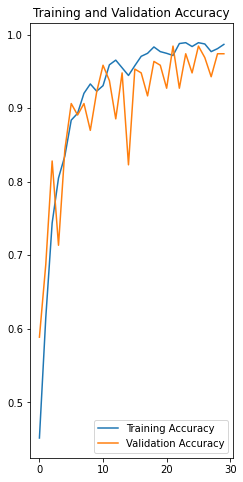

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


Text(0.5, 1.0, 'Training and Validation Loss')

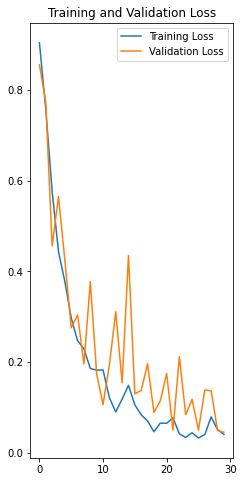

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

first image to predict
actual label:  Potato___Early_blight
predicted label:  Potato___Late_blight


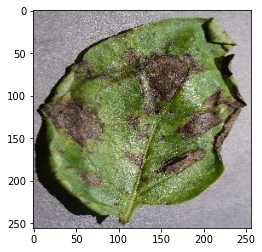

In [76]:
import numpy as np
for images_batch, labels_batch in test_Ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label: ', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #batch create
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence
    
    

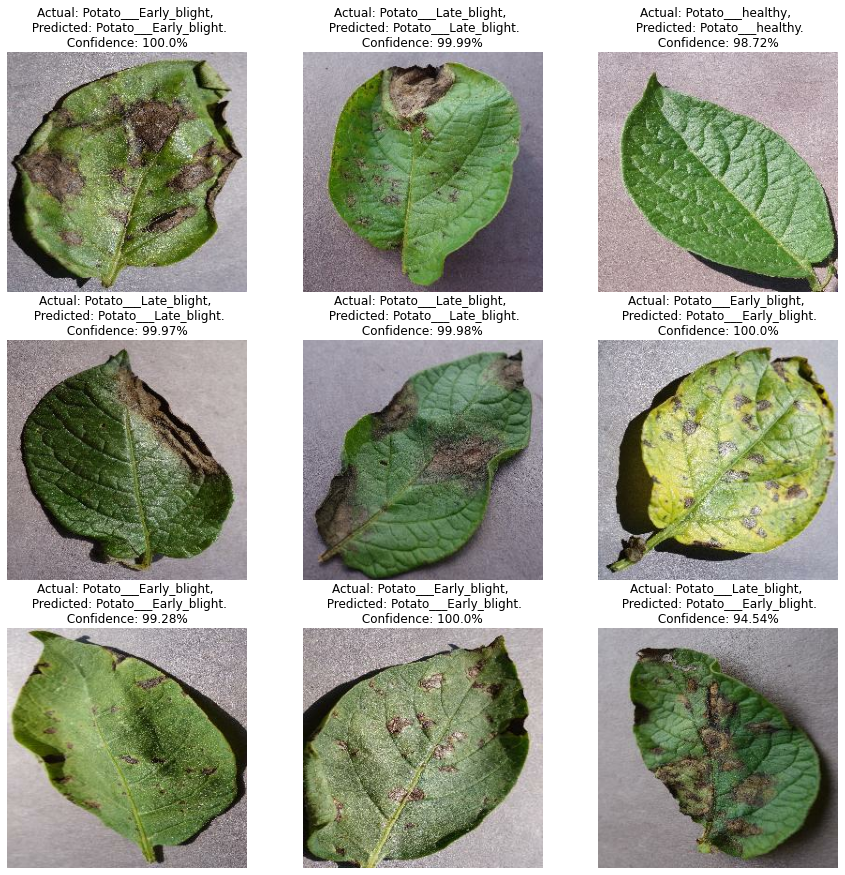

In [82]:
plt.figure(figsize=(15,15))
for images, labels in test_Ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}% ")
        plt.axis("off")          

In [84]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets
